In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
from utils import import_data, compute_KNN_graph, create_graph, create_batch,reconstruct_symmetric_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel


#np.random.seed(11224309)
np.random.seed(3)

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'}


In [3]:
print(torch.__version__)

1.13.1


In [4]:
print(torch_geometric.__version__)

2.1.0


In [5]:
df, phenotypic = import_data(fisher=False)

#df = df.join(pd.DataFrame(phenotypic.Age), how='left')
#df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df['Age'] = phenotypic['Age']

df = df.reset_index()
df = df.dropna(axis=0)
df['Site'] = df['Institution'].astype('category')
df['Site'] = df['Site'].cat.codes

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)


#X = df.drop(columns=['Institution', 'Run', 'Age','ADHD Measure', 'Gender', 'Subject'])
y = df.Gender.astype(int)

In [6]:
df_train = df[~df.Subject.isin(np.random.choice(df['Subject'].unique(),100))]
df_test = df[df.Subject.isin(np.random.choice(df['Subject'].unique(),100))]

Age_train = df_train[['Age']]
Site_train = df_train[['Site']]
X_train = df_train.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site'])
y_train = df_train.Gender

Age_test = df_test[['Age']]
Site_test = df_test[['Site']]
X_test = df_test.drop(columns=['Institution', 'Subject', 'Run', 'Gender', 'Age', 'Site'])
y_test = df_test.Gender

### ----------------------------------

In [7]:
df_train['Institution'].value_counts()

NYU           670
OHSU          424
WashU         258
Pittsburgh    154
Peking_1      154
KKI           144
Peking_2      110
Peking_3       74
NeuroIMAGE     74
Name: Institution, dtype: int64

In [8]:
df_test['Institution'].value_counts()

OHSU          84
NYU           80
WashU         48
Pittsburgh    32
KKI           22
Peking_1      12
Peking_2      10
Peking_3       8
NeuroIMAGE     4
Name: Institution, dtype: int64

In [9]:
# Jeito 2
kfold = np.zeros((3,100))
for i in range(3):
    np.random.seed(i+100)
    kfold[i] = np.random.choice(df['Subject'].unique(),100)

    
df_train = df[~df.Subject.isin(kfold[0])]
df_test = df[df.Subject.isin(kfold[0])]

Age_train = df_train[['Age']]
Site_train = df_train[['Site']]
X_train = df_train.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site'])
y_train = df_train.Gender

Age_test = df_test[['Age']]
Site_test = df_test[['Site']]
X_test = df_test.drop(columns=['Institution', 'Subject', 'Run', 'Gender', 'Age', 'Site'])
y_test = df_test.Gender

In [10]:
df_train['Institution'].value_counts()

NYU           686
OHSU          414
WashU         224
Pittsburgh    152
Peking_1      150
KKI           150
Peking_2      100
NeuroIMAGE     90
Peking_3       72
Name: Institution, dtype: int64

In [11]:
df_test['Institution'].value_counts()

NYU           96
WashU         62
OHSU          54
Peking_2      32
Pittsburgh    22
Peking_1      18
KKI           16
Peking_3      10
NeuroIMAGE     4
Name: Institution, dtype: int64

In [12]:
# arr = df['Subject'].unique()
# np.random.shuffle(arr)
# kfold = np.array_split(arr, 2)  

# df_train = df[~df.Subject.isin(kfold[0])]
# df_test = df[df.Subject.isin(kfold[0])]


# Age_train = df_train[['Age']]
# Site_train = df_train[['Site']]
# X_train = df_train.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site'])
# y_train = df_train.Gender

# Age_test = df_test[['Age']]
# Site_test = df_test[['Site']]
# X_test = df_test.drop(columns=['Institution', 'Subject', 'Run', 'Gender', 'Age', 'Site'])
# y_test = df_test.Gender
    


In [13]:
# kfold[0].shape

In [14]:

# Creating model
model = CombatModel()

# Fitting the model and transforming the training set
X_train = model.fit_transform(X_train.values,
                                         Site_train) #X_train_har

# Harmonize test set using training set fitted parameters
X_test = model.transform(X_test.values,
                                    Site_test) #X_test_har

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
group_fc = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/Group_FC.csv').iloc[:,1]

In [16]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.39% 
 1 = 0.61%


In [17]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_test, y_test)

# Make predictions on the testing data
pred_y = dummy.predict(X_test)

scores = cross_validate(dummy, X_train, y_train, cv=5, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
#print('Dummy accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, dummy.predict(X_TEST))))

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Accuracy in test:0.61(0.00)
F1_scores 0.38(0.00)
Precision_scores 0.30(0.00)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
A = reconstruct_symmetric_matrix(190,group_fc.values)


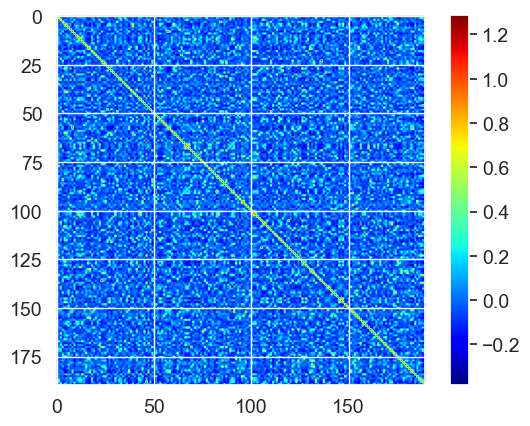

In [19]:
plt.imshow(A, cmap='jet')
plt.colorbar()
plt.show()

## K-NN for selecting edges

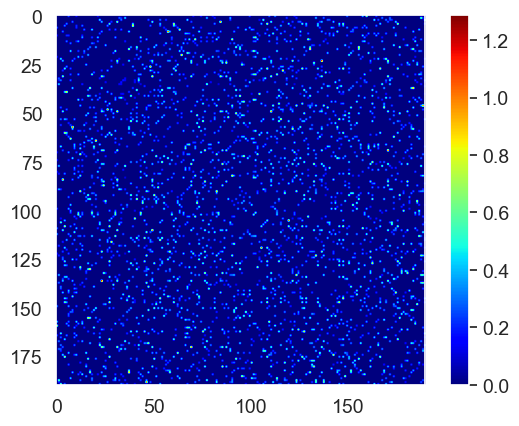

In [20]:
plt.imshow(np.array(compute_KNN_graph(A, 15)),cmap='jet')
plt.colorbar()
plt.grid(False)
plt.show()

## Creating the graphs

In [21]:
train_data, val_data = create_graph(pd.DataFrame(X_train),
                                    pd.DataFrame(X_test), pd.DataFrame(y_train), pd.DataFrame(y_test),
                                    method={'knn_group' : compute_KNN_graph(A, 10)})# method={'knn' : 10}) #,method={'threshold': 0.2})

#train_data, TEST_data = create_graph(X_train, X_TEST, y_train, y_TEST, method={'knn_group' : compute_KNN_graph(A, 10)})# method={'knn' : 10}) #,method={'threshold': 0.2})

In [22]:
print(train_data[-1])

Data(x=[190, 190], edge_index=[2, 2224], edge_attr=[2224, 1], y=1)


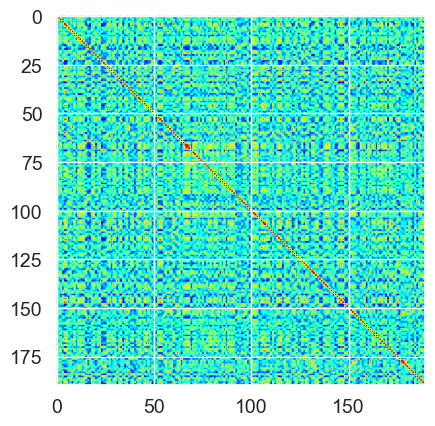

In [23]:
plt.imshow(train_data[-1].x,cmap='jet')

In [85]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=2)

#TRAIN_loader, TEST_loader = create_batch(train_data, TEST_data, batch_size=20)

In [86]:
print('Validation balance \n 0 = {:.2f}% \n'.format(y_test.value_counts()[0]/len(y_test)), '1 = {:.2f}%'.format(y_test.value_counts()[1]/len(y_test)))
print('----------------------')
#print('TEST balance \n 0 = {:.2f}% \n'.format(y_TEST.value_counts()[0]/len(y_TEST)), '1 = {:.2f}%'.format(y_TEST.value_counts()[1]/len(y_TEST)))

Validation balance 
 0 = 0.32% 
 1 = 0.68%
----------------------


In [93]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool, GATv2Conv, global_max_pool


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.4):
        super(GCN, self).__init__()

        self.p = dropout
        
        #self.conv1 = GCNConv(int(num_features), 148)
        #self.conv2 = GCNConv(148,100)
        #self.conv3 = GCNConv(64,32)
        
        #self.gat1 = GATv2Conv(int(num_features),128, heads=4, edge_dim=1)
        #self.gat2 = GATv2Conv(128*4, 64, heads=1)
        #self.gat3 = GATv2Conv(128*2, 148, heads=1)
        
        self.conv1 = ChebConv(int(num_features), 100, K=k_order)
        self.conv2 = ChebConv(100, 128, K=k_order)
        #self.conv3 = ChebConv(64, 128, K=k_order)

        self.lin1 = torch.nn.Linear(128, 2)
        #self.lin2 = torch.nn.Linear(4, int(num_classes))
        
        #torch.nn.init.xavier_normal_(self.gat1)
        #torch.nn.init.xavier_normal_(self.gat2)
        torch.nn.init.xavier_normal_(self.lin1.weight)


        self.bn1 = torch.nn.BatchNorm1d(148)
        self.bn2 = torch.nn.BatchNorm1d(72)
        self.bn3 = torch.nn.BatchNorm1d(36)
        
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        x = func.relu(self.conv1(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        print('1', x.shape)
        #x = func.elu(self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr)) #func.elu(self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn1(x)
        x = func.relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        print('2', x.shape)
        #x = func.elu(self.gat2(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn2(x)
        #x = func.relu(self.conv3(x, edge_index,edge_attr))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat3(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn3(x)
            
        #x = func.elu(self.gat3(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        
        x = self.pool(x, batch)
        print('pool', x.shape)
        print(batch.shape)
        #x = func.log_softmax(x, dim=1)
        x = self.lin1(x)
        print('lin', x.shape)
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.lin2(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        return x

In [95]:
def init_weights(m):
    if isinstance(m, GATv2Conv):
        m.reset_parameters()
        if m.bias is not None: 
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Linear):
        m.reset_parameters()
        #nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(1 / m.in_features))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)


In [96]:
import torch
import torch.nn as nn

# Define the cosine proximity loss function
class CosineProximityLoss(nn.Module):
    def __init__(self):
        super(CosineProximityLoss, self).__init__()
        self.cosine_similarity = nn.CosineSimilarity(dim=1)
    
    def forward(self, y_true, y_pred):
        # y_true and y_pred are tensors of shape (batch_size, num_classes)
        # The loss is the negative of the cosine similarity
        loss = - self.cosine_similarity(y_true, y_pred)
        return loss.mean()
    
#loss = CosineProximityLoss()
#loss = loss(func.softmax(output).max(dim=1).values.reshape(len(y.y),1), y.y.float().reshape(len(y.y),1))
    

# Testing in one fold

In [97]:
def TRAIN_LOSS(loader):
    model.eval()
    l1_weight = 0
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    # fpr, tpr, _ = roc_curve(y_true, y_pred)
    # roc_auc = auc(fpr, tpr)
    
    return epoch_acc, loss_all / len(train_data)

def GCN_train(loader, loop):
    model.train()
    l1_weight = 0
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)
        #print(output)
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, y.y)
        loss_with_penalty = loss + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(train_data))
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
        
    return epoch_acc, loss_all / len(train_data)


def GCN_test(loader):
    
    model.eval()
    l1_weight = 0
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_rec = tp / (tp + fn)
    epoch_prec = tp / (tp + fp)
    epoch_f1 = 2*(epoch_rec*epoch_prec)/(epoch_rec + epoch_prec)
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return epoch_rec, epoch_prec, epoch_acc, loss_all / len(val_data), roc_auc,epoch_f1


In [98]:
metrics = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3 )#,momentum=0.35)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=1, verbose=True)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
   
model.apply(init_weights)

min_v_loss = np.inf  

NUM_EPOCHS = 50

for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_acc, train_loss = GCN_train(train_loader,loop)
    test_rec, test_prec, test_acc, test_loss, roc_auc, test_f1 = GCN_test(val_loader)
    TRAIN_acc, TRAIN_loss = TRAIN_LOSS(train_loader)
    
    scheduler.step()
    
    metrics['loss_train'].append(TRAIN_loss)
    metrics['loss_test'].append(test_loss)
    metrics['acc_test'].append(test_acc)
    metrics['acc_train'].append(TRAIN_acc)
    
    print('Val Accuracy {} , Val Loss {}'.format(test_acc, test_loss))
    print('Train Accuracy {} , Train Loss {}'.format(TRAIN_acc, TRAIN_loss))

#     y_pred = {'x1' : [], 'x2' : [], 'label' : []}
#     for y in val_loader:
#         y_pred['x1'].append(model(y).detach().numpy()[0][0])
#         y_pred['x2'].append(model(y).detach().numpy()[0][1])
#         y_pred['label'].append(y.y.detach().numpy()[0])
        
#     sns.scatterplot(data=pd.DataFrame.from_dict(y_pred) , x='x1', y='x2', hue='label')
#     plt.show()
    

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/50]:   0%|              | 1/1019 [00:00<01:50,  9.22it/s, loss=0.00222]

1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


Epoch [1/50]:   1%|              | 7/1019 [00:00<00:47, 21.23it/s, loss=0.00583]

1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


Epoch [1/50]:   1%|              | 7/1019 [00:00<00:47, 21.23it/s, loss=0.00662]

1 torch.Size([380, 100])


Epoch [1/50]:   1%|▏            | 10/1019 [00:00<00:51, 19.59it/s, loss=0.00821]

2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


Epoch [1/50]:   2%|▏             | 16/1019 [00:00<00:46, 21.37it/s, loss=0.0125]

1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


Epoch [1/50]:   2%|▎             | 22/1019 [00:01<00:46, 21.38it/s, loss=0.0165]

1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


Epoch [1/50]:   3%|▍             | 28/1019 [00:01<00:45, 21.95it/s, loss=0.0186]

1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


Epoch [1/50]:   3%|▍             | 31/1019 [00:01<00:43, 22.80it/s, loss=0.0225]

1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


Epoch [1/50]:   4%|▌             | 37/1019 [00:01<00:45, 21.50it/s, loss=0.0256]

1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


Epoch [1/50]:   4%|▌             | 40/1019 [00:01<00:47, 20.58it/s, loss=0.0275]

1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])
1 torch.Size([380, 100])
2 torch.Size([380, 128])
pool torch.Size([2, 128])
torch.Size([380])
lin torch.Size([2, 2])


KeyboardInterrupt: 


### Debug

In [ ]:
model.eval()

In [ ]:
y_pred = []
for y_i in TEST_loader:
    #print(model(y).detach().numpy()[0][0])
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(np.array(func.softmax(model(y_i), dim=1).detach().max(dim=1)[1]))
    
print('TEST accuracy', accuracy_score(y_TEST.values.reshape(-1,1), y_pred))


In [35]:
y_pred = []
for y_i in val_loader:
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(func.softmax(model(y_i), dim=1).detach().numpy())#.max(dim=1)[1])

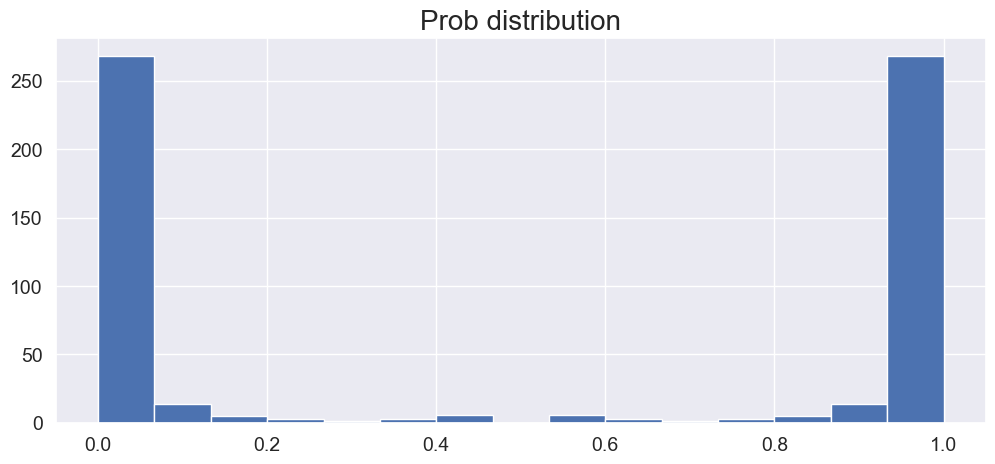

In [36]:
plt.figure(figsize=(12,5))
plt.hist(np.array(y_pred).reshape(len(y_pred)*2), bins=15)
plt.title("Prob distribution")
plt.show()

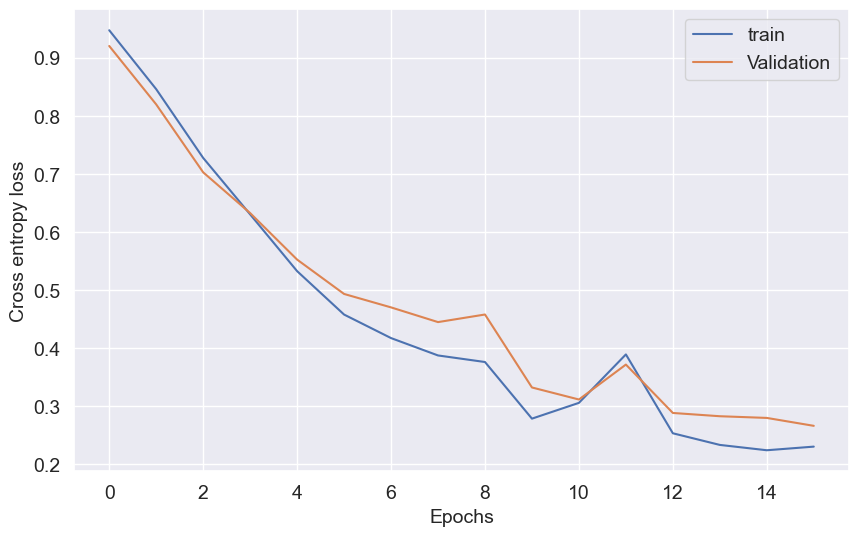

In [37]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Cross entropy loss')
ax.set_xlabel('Epochs')
ax.legend()
#plt.xlim(0,100)
plt.show()

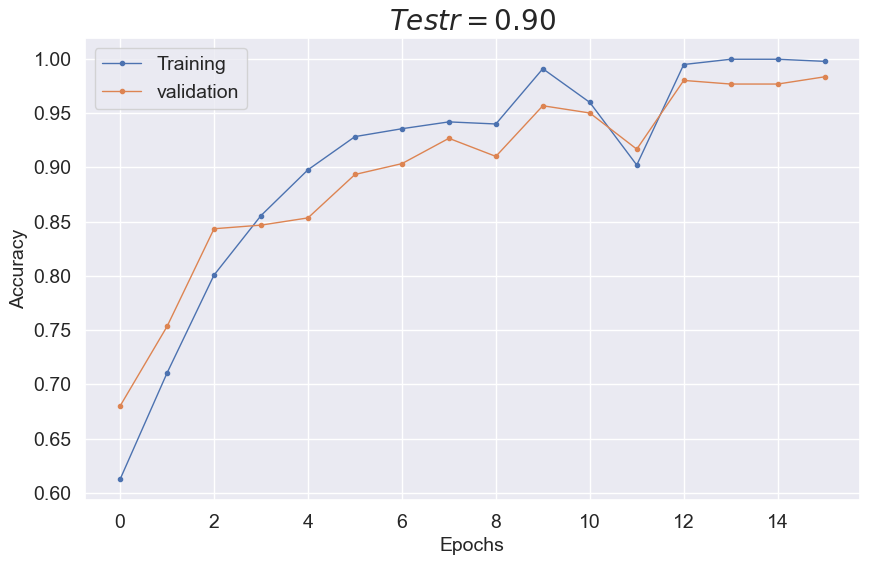

In [38]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['acc_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['acc_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['acc_test'])), metrics['acc_test'])[0][1]))
ax.legend()
plt.show()

## Kfold Cross validation

In [51]:
arr = df['Subject'].unique()
np.random.shuffle(arr)
kfold = np.array_split(arr, 2)

In [52]:

eval_scores = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

scores = np.zeros((6,10))

# K-fold Cross Validation model evaluation
fold_no = 1
for i in range(2):
    test_loss_hist = 0
    
    df_train = df[~df.Subject.isin(kfold[i])]
    df_test = df[df.Subject.isin(kfold[i])]


    Age_train = df_train[['Age']]
    Site_train = df_train[['Site']]
    X_train = df_train.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site'])
    y_train = df_train.Gender

    Age_test = df_test[['Age']]
    Site_test = df_test[['Site']]
    X_test = df_test.drop(columns=['Institution', 'Subject', 'Run', 'Gender', 'Age', 'Site'])
    y_test = df_test.Gender
    
    
    # Creating model
    combat = CombatModel()

    # Fitting the model and transforming the training set
    X_train = combat.fit_transform(X_train.values,
                                             Site_train) #X_train_har

    # Harmonize test set using training set fitted parameters
    X_test = combat.transform(X_test.values,
                                        Site_test) #X_test_har
    
    # creating the graphs
    train_data, val_data = create_graph(pd.DataFrame(X_train),
                                    pd.DataFrame(X_test), pd.DataFrame(y_train), pd.DataFrame(y_test),
                                    method={'knn_group' : compute_KNN_graph(A, 10)})    
    # creating the batchs inside the torch DataLoader
    train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    print(' 0 = {:.2f}% \n'.format(y_test.value_counts()[0]/len(y_test)), '1 = {:.2f}%'.format(y_test.value_counts()[1]/len(y_test)))


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(190, 2, 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)#,momentum=0.35)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=1, verbose=True)

    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    model.apply(init_weights)

    min_v_loss = np.inf  


    NUM_EPOCHS = 5
    for epoch in range(1,NUM_EPOCHS + 1):
        loop = tqdm(train_loader)
        train_acc, train_loss = GCN_train(train_loader,loop)
        test_rec, test_prec, test_acc, test_loss, roc_auc, test_f1  = GCN_test(val_loader)
        TRAIN_acc, TRAIN_loss = TRAIN_LOSS(train_loader)
        
        #if test_loss_hist < test_loss and test_loss_hist != 0:
        #    break
        #test_loss_hist = test_loss
    

        eval_scores['loss_train'].append(TRAIN_loss)
        eval_scores['loss_test'].append(test_loss)
        eval_scores['acc_test'].append(test_acc)
        eval_scores['acc_train'].append(TRAIN_acc)
        
        print('Val Accuracy {} , Val Loss {}'.format(test_acc, test_loss))
        print('Train Accuracy {} , Train Loss {}'.format(TRAIN_acc, TRAIN_loss))

    
    scores[0][fold_no - 1] = test_acc
    scores[1][fold_no - 1] = test_rec
    scores[2][fold_no - 1] = test_prec
    scores[3][fold_no - 1] = test_loss
    scores[4][fold_no - 1] = roc_auc
    scores[5][fold_no - 1] = test_f1

    print(f'Score for fold {fold_no}: loss of {test_loss}; acc of {test_acc}%; AUC of {roc_auc}%')

    # Increase fold number
    fold_no = fold_no + 1

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


------------------------------------------------------------------------
Training for fold 1 ...
 0 = 0.39% 
 1 = 0.61%
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/5]: 100%|██████████████████████| 37/37 [00:26<00:00,  1.37it/s, loss=1]


Val Accuracy 0.6100682593856656 , Val Loss 0.9762543336116413
Train Accuracy 0.6372881355932203 , Train Loss 0.9523952900353124


Epoch [2/5]: 100%|██████████████████| 37/37 [00:07<00:00,  4.77it/s, loss=0.916]


Val Accuracy 0.6117747440273038 , Val Loss 0.9142037321886511
Train Accuracy 0.6923728813559322 , Train Loss 0.860991321983984


Epoch [3/5]: 100%|███████████████████| 37/37 [00:10<00:00,  3.38it/s, loss=0.84]


Val Accuracy 0.6203071672354948 , Val Loss 0.8783486287392447
Train Accuracy 0.6957627118644067 , Train Loss 0.7665921154668776


Epoch [4/5]: 100%|██████████████████| 37/37 [00:07<00:00,  5.21it/s, loss=0.758]


Val Accuracy 0.6092150170648464 , Val Loss 0.9020467265397819
Train Accuracy 0.690677966101695 , Train Loss 0.7059930724612737


Epoch [5/5]: 100%|██████████████████| 37/37 [00:13<00:00,  2.81it/s, loss=0.665]


Val Accuracy 0.6228668941979523 , Val Loss 0.9177375205191736
Train Accuracy 0.7610169491525424 , Train Loss 0.6105231143660464
Score for fold 1: loss of 0.9177375205191736; acc of 0.6228668941979523%; AUC of 0.5318517163587586%


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


------------------------------------------------------------------------
Training for fold 2 ...
 0 = 0.38% 
 1 = 0.62%
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/5]: 100%|██████████████████████| 37/37 [00:08<00:00,  4.23it/s, loss=1]


Val Accuracy 0.6237288135593221 , Val Loss 0.9468144746907686
Train Accuracy 0.60580204778157 , Train Loss 0.9458917865574157


Epoch [2/5]: 100%|███████████████████| 37/37 [00:06<00:00,  5.39it/s, loss=0.91]


Val Accuracy 0.6245762711864407 , Val Loss 0.873969149892613
Train Accuracy 0.6092150170648464 , Train Loss 0.8567246975752274


Epoch [3/5]: 100%|██████████████████| 37/37 [00:07<00:00,  5.14it/s, loss=0.833]


Val Accuracy 0.6279661016949153 , Val Loss 0.8246804309851032
Train Accuracy 0.6450511945392492 , Train Loss 0.774031275164959


Epoch [4/5]: 100%|██████████████████| 37/37 [00:06<00:00,  5.45it/s, loss=0.764]


Val Accuracy 0.6025423728813559 , Val Loss 0.8006227015943851
Train Accuracy 0.764505119453925 , Train Loss 0.6975072402596066


Epoch [5/5]: 100%|██████████████████| 37/37 [00:06<00:00,  5.67it/s, loss=0.683]


Val Accuracy 0.5957627118644068 , Val Loss 0.7899511291566542
Train Accuracy 0.8191126279863481 , Train Loss 0.6093555432537717
Score for fold 2: loss of 0.7899511291566542; acc of 0.5957627118644068%; AUC of 0.5566612808460635%


In [24]:
print('Average Accuracy in CV: {:.2f}({:.2f}) \n'.format(scores[0].mean(), scores[0].std()))
print('Average Recall in CV: {:.2f}({:.2f}) \n'.format(scores[1].mean(), scores[1].std()))
print('Average Precision in CV: {:.2f}({:.2f}) \n'.format(scores[2].mean(), scores[2].std()))
print('Average Loss in test CV: {:.2f}({:.2f}) \n'.format(scores[3].mean(), scores[3].std()))
print('Average AUC in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))
print('Average F1 in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))

Average Accuracy in CV: 0.00(0.00) 

Average Recall in CV: 0.00(0.00) 

Average Precision in CV: 0.00(0.00) 

Average Loss in test CV: 0.00(0.00) 

Average AUC in test CV: 0.00(0.00) 

Average F1 in test CV: 0.00(0.00) 



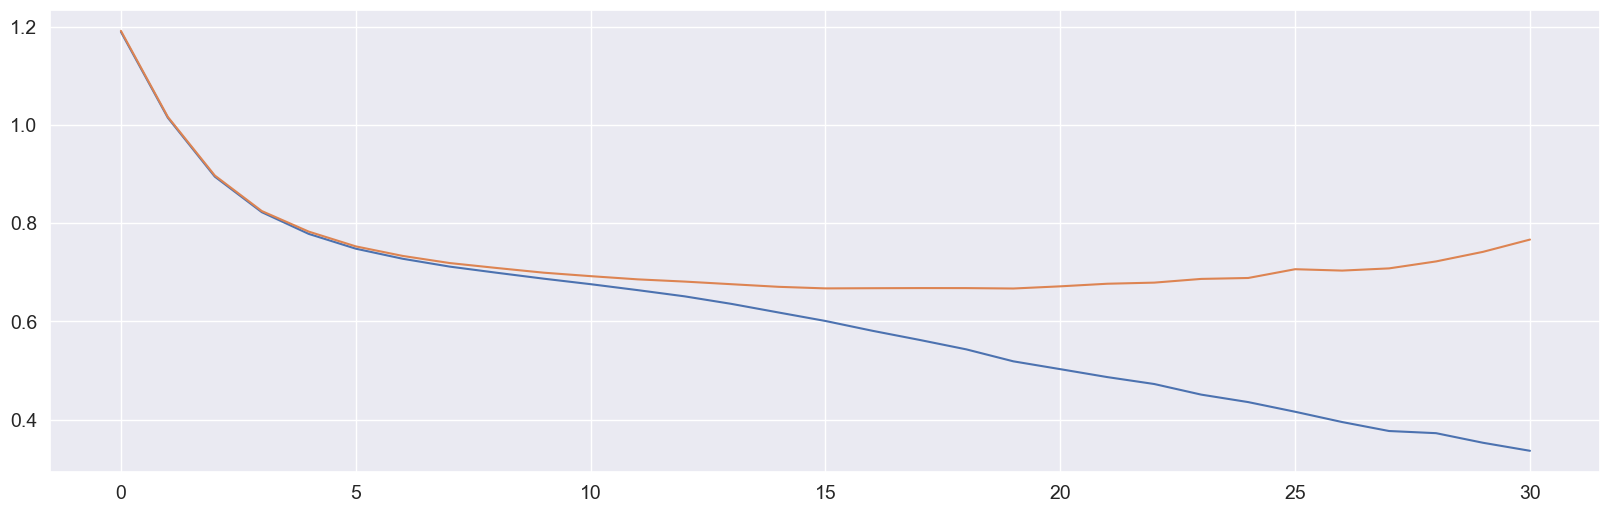

In [25]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['loss_train'])
plt.plot(eval_scores['loss_test'])

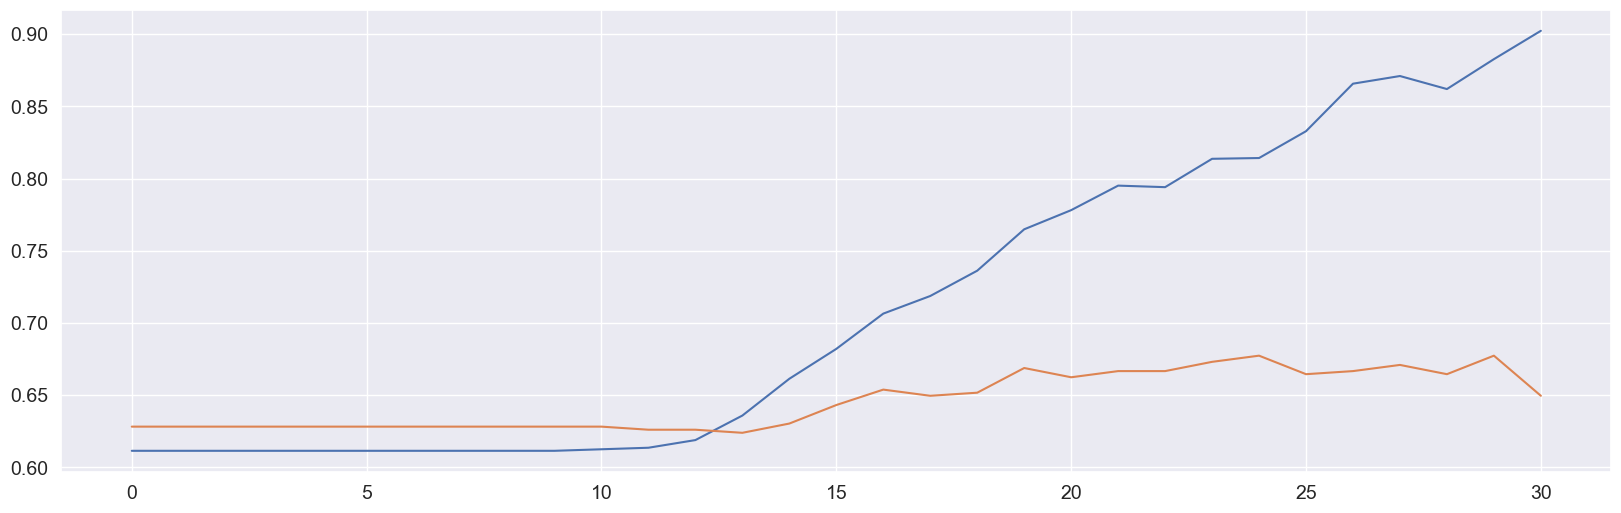

In [26]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['acc_train'])
plt.plot(eval_scores['acc_test'])

In [138]:
pd.DataFrame(scores.T, columns=['test_acc', 'test_rec_macro',
                                'test_prec_macro', 'test_loss',
                                'test_f1', 'test_roc_auc']).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/GAT.csv')